# Phase 3: Baseline Models & Time-Series CV

This notebook implements baseline models and time-series cross-validation.

**Objectives:**
- Load featured data from Phase 2
- Implement expanding window time-series cross-validation
- Train naive baseline (last week's sales)
- Train simple LightGBM baseline
- Evaluate models using RMSPE metric
- Save baseline metrics for comparison

**CRITICAL:** All CV uses expanding windows with strict temporal ordering to prevent data leakage.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from evaluation.cv import (
    make_time_series_folds,
    get_fold_summary,
    filter_open_stores,
    remove_missing_features
)
from evaluation.metrics import rmspe
from evaluation.reporting import (
    save_cv_results,
    print_cv_summary,
    compare_models
)
from models.train_baselines import (
    naive_last_week_model,
    simple_lightgbm_baseline,
    get_feature_columns
)
from utils.io import read_parquet, ensure_dir

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Ensure output directories
ensure_dir('../outputs/metrics/baseline')

print("Setup complete!")

Setup complete!


## 1. Load Featured Data

In [2]:
# Load featured data from Phase 2
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"\nColumns: {len(df.columns)}")
print(f"Features: {len(df.columns) - 18}")  # Approx features (total - original cols)

Loaded data shape: (1017209, 50)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Number of stores: 1115

Columns: 50
Features: 32


## 2. Load Configuration

In [3]:
# Load CV config from params.yaml
with open('../config/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

cv_config = params['cv']

print("Cross-Validation Configuration:")
print(f"  Method: {cv_config['method']}")
print(f"  Number of folds: {cv_config['n_folds']}")
print(f"  Fold length: {cv_config['fold_length_days']} days ({cv_config['fold_length_days']//7} weeks)")
print(f"  Minimum train days: {cv_config['min_train_days']} days ({cv_config['min_train_days']//365} year)")

Cross-Validation Configuration:
  Method: expanding
  Number of folds: 5
  Fold length: 42 days (6 weeks)
  Minimum train days: 365 days (1 year)


## 3. Filter Data

Remove closed stores (Open=0) as they have Sales=0 and are ignored in RMSPE.

In [4]:
# Filter to open stores only
initial_size = len(df)
df_open = filter_open_stores(df)

print(f"\nFiltered {initial_size - len(df_open):,} closed store-days")
print(f"Remaining: {len(df_open):,} open store-days")

2025-12-02 08:22:25 - evaluation.cv - INFO - Filtered out 172,817 closed store-days (16.99%)
2025-12-02 08:22:25 - evaluation.cv - INFO - Remaining: 844,392 open store-days

Filtered 172,817 closed store-days
Remaining: 844,392 open store-days


## 4. Create Time-Series CV Folds

Use expanding window splits where each fold trains on all historical data.

In [5]:
# Create CV folds
folds = make_time_series_folds(
    df_open,
    n_folds=cv_config['n_folds'],
    fold_length_days=cv_config['fold_length_days'],
    min_train_days=cv_config['min_train_days']
)

print(f"\nCreated {len(folds)} CV folds")

2025-12-02 08:22:25 - evaluation.cv - INFO - ============================================================
2025-12-02 08:22:25 - evaluation.cv - INFO - Creating time-series cross-validation folds
2025-12-02 08:22:25 - evaluation.cv - INFO - ============================================================
2025-12-02 08:22:25 - evaluation.cv - INFO - Number of folds: 5
2025-12-02 08:22:25 - evaluation.cv - INFO - Validation fold length: 42 days (6 weeks)
2025-12-02 08:22:25 - evaluation.cv - INFO - Minimum training days: 365 days (1 year)
2025-12-02 08:22:25 - evaluation.cv - INFO - Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
2025-12-02 08:22:25 - evaluation.cv - INFO - Total unique dates: 942
2025-12-02 08:22:25 - evaluation.cv - INFO - 
First validation period starts at: 2014-01-01 00:00:00
2025-12-02 08:22:25 - evaluation.cv - INFO - 
Fold 1:
2025-12-02 08:22:25 - evaluation.cv - INFO -   Train: 2013-01-01 00:00:00 to 2013-12-31 00:00:00 (337,943 samples)
2025-12-02 08:22:25 - e

In [6]:
# Get fold summary
fold_summary = get_fold_summary(df_open, folds)

print("\nFold Summary:")
display(fold_summary)


Fold Summary:


,fold,train_start,train_end,train_size,val_start,val_end,val_size,train_days,val_days
0,1,2013-01-01,2013-12-31,337943,2014-01-01,2014-02-11,38761,365,42
1,2,2013-01-01,2014-02-11,376704,2014-02-12,2014-03-25,40164,407,42
2,3,2013-01-01,2014-03-25,416868,2014-03-26,2014-05-06,37018,449,42
3,4,2013-01-01,2014-05-06,453886,2014-05-07,2014-06-17,38108,491,42
4,5,2013-01-01,2014-06-17,491994,2014-06-18,2014-07-29,34985,533,42


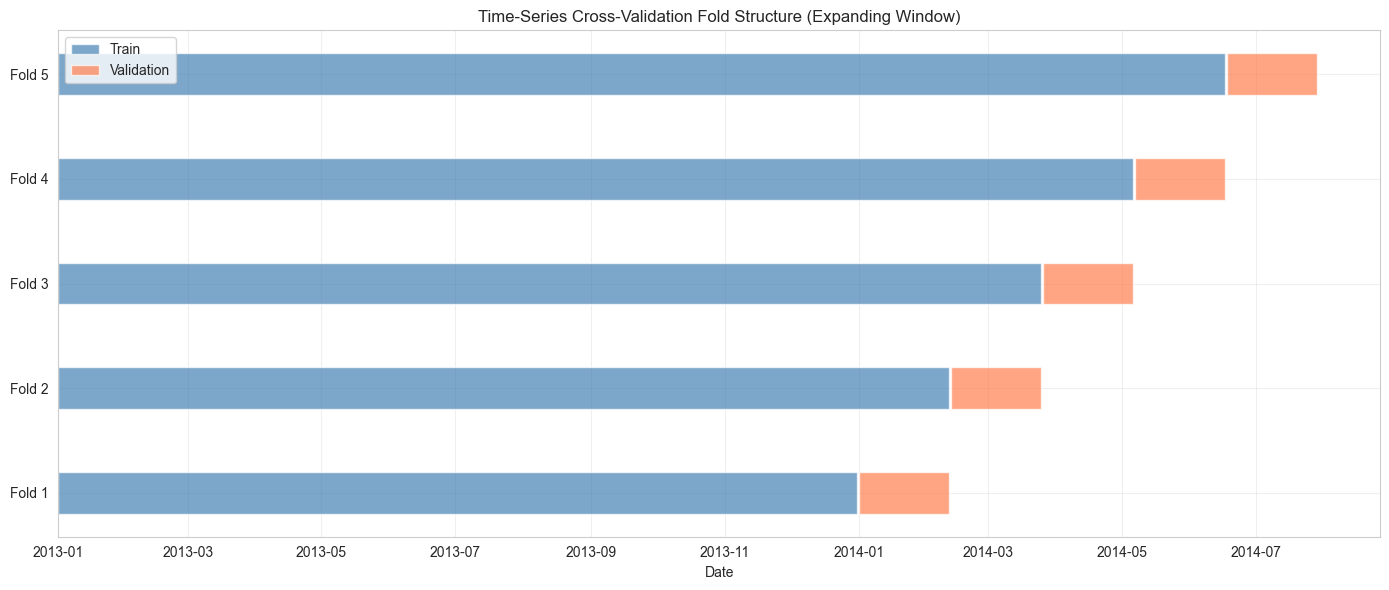

Saved: outputs/figures/10_cv_fold_structure.png


In [7]:
# Visualize fold structure
fig, ax = plt.subplots(figsize=(14, 6))

for idx, row in fold_summary.iterrows():
    # Training period
    ax.barh(idx, (row['train_end'] - row['train_start']).days, 
            left=row['train_start'], 
            height=0.4, 
            color='steelblue', 
            alpha=0.7,
            label='Train' if idx == 0 else '')
    
    # Validation period
    ax.barh(idx, (row['val_end'] - row['val_start']).days, 
            left=row['val_start'], 
            height=0.4, 
            color='coral', 
            alpha=0.7,
            label='Validation' if idx == 0 else '')

ax.set_yticks(range(len(fold_summary)))
ax.set_yticklabels([f"Fold {i+1}" for i in range(len(fold_summary))])
ax.set_xlabel('Date')
ax.set_title('Time-Series Cross-Validation Fold Structure (Expanding Window)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/10_cv_fold_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/figures/10_cv_fold_structure.png")

## 5. Naive Baseline: Last Week Model

Simple baseline that predicts current sales using last week's sales (7-day lag).

In [8]:
# Train naive baseline
naive_results = naive_last_week_model(df_open, folds)

# Print summary
print_cv_summary(naive_results)

2025-12-02 08:22:25 - models.train_baselines - INFO - ============================================================
2025-12-02 08:22:25 - models.train_baselines - INFO - Training Naive Last-Week Model
2025-12-02 08:22:25 - models.train_baselines - INFO - ============================================================
2025-12-02 08:22:25 - models.train_baselines - INFO - Using Sales_Lag_7 as prediction
2025-12-02 08:22:25 - models.train_baselines - INFO - Fold 1: RMSPE = 0.524278
2025-12-02 08:22:25 - models.train_baselines - INFO - Fold 2: RMSPE = 0.426037
2025-12-02 08:22:25 - models.train_baselines - INFO - Fold 3: RMSPE = 0.485246
2025-12-02 08:22:25 - models.train_baselines - INFO - Fold 4: RMSPE = 0.452121
2025-12-02 08:22:25 - models.train_baselines - INFO - Fold 5: RMSPE = 0.450921
2025-12-02 08:22:25 - models.train_baselines - INFO - 
Mean RMSPE: 0.467721 ± 0.033968
2025-12-02 08:22:25 - models.train_baselines - INFO - ============================================================
Na

In [9]:
# Save results
save_cv_results(naive_results, 'naive_lastweek', '../outputs/metrics/baseline')

print("Saved naive baseline results")

2025-12-02 08:22:25 - evaluation.reporting - INFO - Saved CV results to ../outputs/metrics/baseline/naive_lastweek_cv_results.json
Saved naive baseline results


## 6. Simple LightGBM Baseline

Train a basic LightGBM model with default parameters.

In [10]:
# Get feature columns
feature_cols = get_feature_columns(df_open)

print(f"Identified {len(feature_cols)} feature columns")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Identified 46 feature columns

Feature columns:
  1. DayOfWeek
  2. Open
  3. Promo
  4. StateHoliday
  5. SchoolHoliday
  6. StoreType
  7. Assortment
  8. CompetitionDistance
  9. CompetitionOpenSinceMonth
  10. CompetitionOpenSinceYear
  11. Promo2
  12. Promo2SinceWeek
  13. Promo2SinceYear
  14. PromoInterval
  15. Year
  16. Month
  17. Week
  18. Day
  19. DayOfMonth
  20. Quarter
  21. IsMonthStart
  22. IsMonthEnd
  23. IsQuarterStart
  24. IsQuarterEnd
  25. IsWeekend
  26. Season
  27. Promo2Active
  28. Promo2Duration
  29. PromoInterval_JAJO
  30. PromoInterval_FMAN
  31. PromoInterval_MJSD
  32. CompetitionDistance_log
  33. HasCompetition
  34. CompetitionAge
  35. Sales_Lag_1
  36. Sales_Lag_7
  37. Sales_Lag_14
  38. Sales_Lag_28
  39. Sales_RollingMean_7
  40. Sales_RollingStd_7
  41. Sales_RollingMean_14
  42. Sales_RollingStd_14
  43. Sales_RollingMean_28
  44. Sales_RollingStd_28
  45. Sales_RollingMean_60
  46. Sales_RollingStd_60


In [11]:
# Train LightGBM baseline
lgb_results = simple_lightgbm_baseline(df_open, folds, feature_cols)

# Print summary
print_cv_summary(lgb_results)

2025-12-02 08:22:25 - models.train_baselines - INFO - ============================================================
2025-12-02 08:22:25 - models.train_baselines - INFO - Training Simple LightGBM Baseline
2025-12-02 08:22:25 - models.train_baselines - INFO - ============================================================
2025-12-02 08:22:25 - models.train_baselines - INFO - Number of features: 46
2025-12-02 08:22:25 - models.train_baselines - INFO - Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
2025-12-02 08:22:25 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-02 08:22:25 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-02 08:22:25 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-02 08:22:25 - evaluation.cv - INFO - Remaining: 38,761 compl

In [12]:
# Save results
save_cv_results(lgb_results, 'lightgbm_baseline', '../outputs/metrics/baseline')

print("Saved LightGBM baseline results")

2025-12-02 08:22:54 - evaluation.reporting - INFO - Saved CV results to ../outputs/metrics/baseline/lightgbm_baseline_cv_results.json
Saved LightGBM baseline results


## 7. Compare Baseline Models

In [13]:
# Compare models
results_dict = {
    'Naive Last-Week': naive_results,
    'LightGBM Baseline': lgb_results
}

comparison_df = compare_models(results_dict)

print("\nModel Comparison:")
display(comparison_df)


Model Comparison:


,Model,Mean RMSPE,Std RMSPE,Min RMSPE,Max RMSPE,Num Folds
0,LightGBM Baseline,0.140874,0.019288,0.119805,0.169302,5
1,Naive Last-Week,0.467721,0.033968,0.426037,0.524278,5


/var/folders/8f/c06lv6q17tjbyjv2nkt0_s4s1sh0tg/T/ipykernel_92769/2419699649.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fold_scores, labels=['Naive', 'LightGBM'], patch_artist=True)


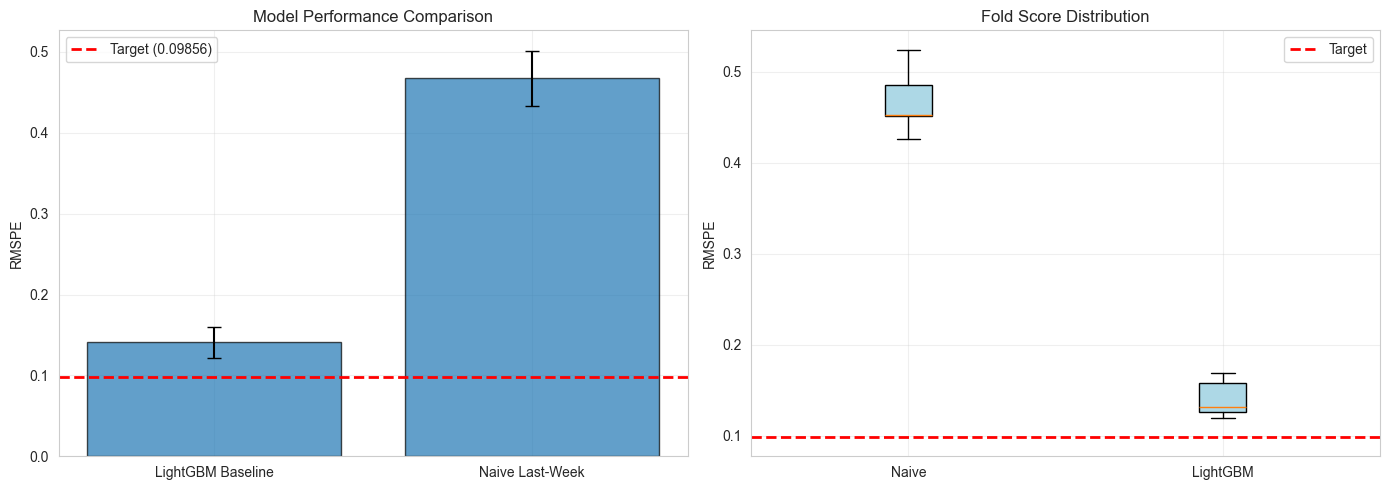

Saved: outputs/figures/11_baseline_comparison.png


In [14]:
# Visualize comparisonfig, axes = plt.subplots(1, 2, figsize=(14, 5))# Bar plot of mean RMSPEax = axes[0]models = comparison_df['Model']means = comparison_df['Mean RMSPE']stds = comparison_df['Std RMSPE']ax.bar(range(len(models)), means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')ax.set_xticks(range(len(models)))ax.set_xticklabels(models, rotation=0)ax.set_ylabel('RMSPE')ax.set_title('Model Performance Comparison')ax.axhline(y=0.09856, color='red', linestyle='--', label='Target (0.09856)', linewidth=2)ax.legend()ax.grid(True, alpha=0.3)# Box plot of fold scoresax = axes[1]fold_scores = [naive_results['fold_scores'], lgb_results['fold_scores']]bp = ax.boxplot(fold_scores, tick_labels=['Naive', 'LightGBM'], patch_artist=True)for patch in bp['boxes']:    patch.set_facecolor('lightblue')ax.set_ylabel('RMSPE')ax.set_title('Fold Score Distribution')ax.axhline(y=0.09856, color='red', linestyle='--', label='Target', linewidth=2)ax.legend()ax.grid(True, alpha=0.3)plt.tight_layout()plt.savefig('../outputs/figures/11_baseline_comparison.png', dpi=300, bbox_inches='tight')plt.show()print("Saved: outputs/figures/11_baseline_comparison.png")

## 8. Analysis of Results

In [15]:
print("="*60)
print("BASELINE MODEL ANALYSIS")
print("="*60)

# Calculate improvement
naive_mean = naive_results['mean_score']
lgb_mean = lgb_results['mean_score']
improvement = (naive_mean - lgb_mean) / naive_mean * 100

print(f"\nNaive Last-Week Model:")
print(f"  Mean RMSPE: {naive_mean:.6f}")
print(f"  This is our simplest baseline - just using last week's sales")

print(f"\nLightGBM Baseline:")
print(f"  Mean RMSPE: {lgb_mean:.6f}")
print(f"  Improvement over naive: {improvement:.2f}%")

print(f"\nTarget Performance:")
print(f"  Target RMSPE: 0.09856 (top 50 leaderboard)")
print(f"  Gap to target: {(lgb_mean - 0.09856):.6f}")
print(f"  Additional improvement needed: {((lgb_mean - 0.09856) / lgb_mean * 100):.2f}%")

print("\nNext Steps:")
print("  Phase 4 will focus on:")
print("  - Hyperparameter tuning")
print("  - Advanced models (XGBoost, CatBoost)")
print("  - Ensemble methods")
print("  - Additional feature engineering if needed")

print("="*60)

BASELINE MODEL ANALYSIS

Naive Last-Week Model:
  Mean RMSPE: 0.467721
  This is our simplest baseline - just using last week's sales

LightGBM Baseline:
  Mean RMSPE: 0.140874
  Improvement over naive: 69.88%

Target Performance:
  Target RMSPE: 0.09856 (top 50 leaderboard)
  Gap to target: 0.042314
  Additional improvement needed: 30.04%

Next Steps:
  Phase 4 will focus on:
  - Hyperparameter tuning
  - Advanced models (XGBoost, CatBoost)
  - Ensemble methods
  - Additional feature engineering if needed


## 9. Summary

In [16]:
print("\n" + "="*60)
print("Phase 3 Complete!")
print("="*60)
print(f"Implemented time-series CV with {len(folds)} expanding window folds")
print(f"Trained and evaluated 2 baseline models")
print(f"\nBest baseline: LightGBM with RMSPE = {lgb_mean:.6f}")
print(f"Baseline metrics saved to: outputs/metrics/baseline/")
print(f"\nReady for Phase 4: Advanced Models & Ensembles")
print("="*60)


Phase 3 Complete!
Implemented time-series CV with 5 expanding window folds
Trained and evaluated 2 baseline models

Best baseline: LightGBM with RMSPE = 0.140874
Baseline metrics saved to: outputs/metrics/baseline/

Ready for Phase 4: Advanced Models & Ensembles
